In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata

# Preprocess the data

path_data = './data/2021VAERSDATA.csv'
path_vax = './data/2021VAERSVAX.csv'

df_data = pd.read_csv(path_data, dtype='unicode')
df_vax = pd.read_csv(path_vax, dtype='unicode')

df_vax = df_vax[['VAX_MANU', 'VAX_DOSE_SERIES']].copy()
df = df_data[['AGE_YRS', 'SEX']].copy()
df = pd.concat([df,df_vax], axis=1, join="inner")

# Target variables: Died, Life Threatening, Hospitalized, Disabled, Recovered
df_outcomes = df_data[['DIED', 'L_THREAT', 'HOSPITAL', 'DISABLE', 'RECOVD']].copy()
df = pd.concat([df,df_outcomes], axis=1, join="inner")

print(df.head())
print(df.info())

  AGE_YRS SEX         VAX_MANU VAX_DOSE_SERIES DIED L_THREAT HOSPITAL DISABLE  \
0    33.0   F          MODERNA               1  NaN      NaN      NaN     NaN   
1    73.0   F          MODERNA               1  NaN      NaN      NaN     NaN   
2    23.0   F  PFIZER\BIONTECH               1  NaN      NaN      NaN     NaN   
3    58.0   F          MODERNA             UNK  NaN      NaN      NaN     NaN   
4    47.0   F          MODERNA               1  NaN      NaN      NaN     NaN   

  RECOVD  
0      Y  
1      Y  
2      U  
3      Y  
4      N  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146622 entries, 0 to 146621
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   AGE_YRS          131782 non-null  object
 1   SEX              146622 non-null  object
 2   VAX_MANU         146622 non-null  object
 3   VAX_DOSE_SERIES  145639 non-null  object
 4   DIED             3731 non-null    object
 5   L_THREAT  

In [2]:
# Normalize and scale the data

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# AGE_YEARS
# Remove rows with missing values;
# Change data type to float
df.drop(df[df['AGE_YRS'].isna()].index, inplace = True)
df["AGE_YRS"] = df["AGE_YRS"].astype(str).astype(float)

# SEX
# Remove rows with blank cells
df.drop(df[df['SEX'].isna()].index, inplace = True)

# VAX_MANU
# Contains: 'DYNAVAX TECHNOLOGIES CORPORATION', 'EMERGENT BIOSOLUTIONS', 'GLAXOSMITHKLINE BIOLOGICALS', 'JANSSEN', 'MERCK & CO. INC.', 'MODERNA', 'NOVARTIS VACCINES AND DIAGNOSTICS', 'PFIZER\\BIONTECH', 'PFIZER\\WYETH', 'PROTEIN SCIENCES CORPORATION', 'SANOFI PASTEUR', 'SEQIRUS, INC.', 'TEVA PHARMACEUTICALS', 'UNKNOWN MANUFACTURER'
# Remove rows where VZX_MANU is not Moderna, Pfizer\Biotech, or Janssen
df.drop(df[(df['VAX_MANU']!="MODERNA") & (df['VAX_MANU']!="PFIZER\BIONTECH") &(df['VAX_MANU']!="JANSSEN")].index, inplace = True)

# VAX_DOSE_SERIES
# Remove rows where VAX_DOSE_SERIES is not 1 or 2
# Change data type
df.drop(df[(df['VAX_DOSE_SERIES']!="1") & (df['VAX_DOSE_SERIES']!="2")].index, inplace = True)
df["VAX_DOSE_SERIES"] = df["VAX_DOSE_SERIES"].astype(str).astype(int)

# RECOVD
# Remove rows where RECOVD is not 1 or 2
df.drop(df[(df['RECOVD']!="Y") & (df['RECOVD']!="N")].index, inplace = True)

# Update indeces
df = df.reset_index().copy()
del df['index']

# cleaned 44.2% of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81490 entries, 0 to 81489
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AGE_YRS          81490 non-null  float64
 1   SEX              81490 non-null  object 
 2   VAX_MANU         81490 non-null  object 
 3   VAX_DOSE_SERIES  81490 non-null  int32  
 4   DIED             2147 non-null   object 
 5   L_THREAT         1950 non-null   object 
 6   HOSPITAL         5250 non-null   object 
 7   DISABLE          1532 non-null   object 
 8   RECOVD           81490 non-null  object 
dtypes: float64(1), int32(1), object(7)
memory usage: 5.3+ MB


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Scale or encode the values
encoder_SEX = LabelEncoder()
encoder_VAX_MANU = LabelEncoder()
encoder_DIED = LabelEncoder()
encoder_L_THREAT = LabelEncoder()
encoder_HOSPITAL = LabelEncoder()
encoder_DISABLE = LabelEncoder()
encoder_RECOVD = LabelEncoder()
scaler_AGE_YRS = MinMaxScaler() 

# Encode: SEX(Male=1; Female=0); DIED(Y=0; NaN=1); L_THREAT(Y=0; NaN=1); HOSPITAL(Y=0; NaN=1); DISABLE(Y=0; NaN=1); RECOVD(Y=1; N=0); VAX_MENU(...)
df[["SEX"]] = encoder_SEX.fit_transform(np.ravel(df["SEX"]))
df[["VAX_MANU"]] = encoder_VAX_MANU.fit_transform(np.ravel(df["VAX_MANU"]))
df[["DIED"]] = encoder_DIED.fit_transform(np.ravel(df["DIED"]))
df[["L_THREAT"]] = encoder_L_THREAT.fit_transform(np.ravel(df["L_THREAT"]))
df[["HOSPITAL"]] = encoder_HOSPITAL.fit_transform(np.ravel(df["HOSPITAL"]))
df[["DISABLE"]] = encoder_DISABLE.fit_transform(np.ravel(df["DISABLE"]))
df[["RECOVD"]] = encoder_RECOVD.fit_transform(np.ravel(df["RECOVD"]))

# Scale: AGE_YRS, VAX_MANU
df[["AGE_YRS"]] = scaler_AGE_YRS.fit_transform(df[["AGE_YRS"]])

df.head()
#df.info()

,AGE_YRS,SEX,VAX_MANU,VAX_DOSE_SERIES,DIED,L_THREAT,HOSPITAL,DISABLE,RECOVD
0,0.276825,0,1,1,1,1,1,1,1
1,0.613185,0,1,1,1,1,1,1,1
2,0.394551,0,1,1,1,1,1,1,0
3,0.369324,0,1,1,1,1,1,1,1
4,0.596367,0,1,1,1,1,1,1,0


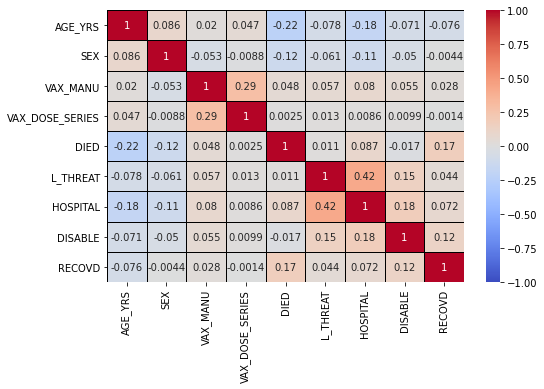

In [5]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,5))  
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=1, linecolor='black')
plt.show()

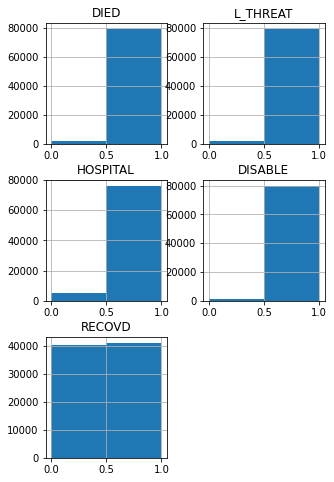

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statistics

X = df[['AGE_YRS', 'SEX', 'VAX_MANU', 'VAX_DOSE_SERIES']].copy()
Y = df[['DIED', 'L_THREAT', 'HOSPITAL', 'DISABLE', 'RECOVD']].copy()

ax = Y.hist(bins=2, figsize=(5,8))


In [41]:
#L_THREAT = life threatening
Y_list = Y.columns.tolist()

# initialize list of models
model_list = list(map(lambda _ : LogisticRegression(), Y_list))
    
for i, y in enumerate(Y_list):   
    x_train, x_test, y_train, y_test = train_test_split(X, df[y], test_size =0.3)
    model_list[i].fit(x_train, y_train)
    
    # change the flag when working on RECOVD because RECOVD(N=0;Y=1) and others are(N=1;Y=0)
    flag = 1 if y == 'RECOVD' else 0

    print("Probability of", Y_list[i], "is: ", statistics.mean(model_list[i].predict_proba(x_test)[::,flag]))
    
print(Y.columns.tolist())

Probability of DIED is:  0.02661347986844842
Probability of L_THREAT is:  0.02376638335879918
Probability of HOSPITAL is:  0.06423874234610757
Probability of DISABLE is:  0.019008953796386625
Probability of RECOVD is:  0.5068595536771916
['DIED', 'L_THREAT', 'HOSPITAL', 'DISABLE', 'RECOVD']


In [58]:
import joblib
import os

BASE_DIR = "../src/models/outcomes-sklearn/"

# clear dir
for file in os.listdir(BASE_DIR):
    os.remove(os.path.join(BASE_DIR, file))

# save models
for i, model in enumerate(model_list):
    model_name = Y_list[i]
    model_path = f"{BASE_DIR}model_{model_name}.pkl"
    joblib.dump(model, model_path)

# Save encoders
joblib.dump(encoder_SEX, os.path.join(BASE_DIR, "encoder_SEX.pkl"))
joblib.dump(encoder_VAX_MANU, os.path.join(BASE_DIR, "encoder_VAX_MANU.pkl"))
joblib.dump(encoder_DIED, os.path.join(BASE_DIR, "encoder_DIED.pkl"))
joblib.dump(encoder_L_THREAT, os.path.join(BASE_DIR, "encoder_L_THREAT.pkl"))
joblib.dump(encoder_HOSPITAL, os.path.join(BASE_DIR, "encoder_HOSPITAL.pkl"))
joblib.dump(encoder_DISABLE, os.path.join(BASE_DIR, "encoder_DISABLE.pkl"))
joblib.dump(encoder_RECOVD, os.path.join(BASE_DIR, "encoder_RECOVD.pkl"))
joblib.dump(scaler_AGE_YRS, os.path.join(BASE_DIR, "scaler_AGE_YRS.pkl"))

['../src/models/outcomes-sklearn/scaler_AGE_YRS.pkl']

In [9]:
# load model from filesystem
model_ = joblib.load(os.path.join(BASE_DIR, "outcomes.pkl")
model_

LogisticRegression()

In [15]:
sample_ = x_train.iloc[1]
print(sample_)
sample_array_ = np.array(sample_)
sample_array_

AGE_YRS            0.31887
SEX                0.00000
VAX_MANU           2.00000
VAX_DOSE_SERIES    2.00000
Name: 62393, dtype: float64


array([0.31886983, 0.        , 2.        , 2.        ])

In [18]:
model_.predict_proba([sample_array_])

array([[0.4575052, 0.5424948]])

In [19]:
print(df.columns)

Index(['AGE_YRS', 'SEX', 'VAX_MANU', 'VAX_DOSE_SERIES', 'DIED', 'L_THREAT',
       'HOSPITAL', 'DISABLE', 'RECOVD'],
      dtype='object')


In [56]:
print(0 if encoder_DIED.inverse_transform([0]) == ['Y'] else 1)
print(0 if encoder_L_THREAT.inverse_transform([0]) == ['Y'] else 1)
print(0 if encoder_HOSPITAL.inverse_transform([0]) == ['Y'] else 1)
print(0 if encoder_DISABLE.inverse_transform([0]) == ['Y'] else 1)
print(0 if encoder_RECOVD.inverse_transform([0]) == ['Y'] else 1)
print("this is to grab the correct index")

0
0
0
0
1
this is to grab the correct index
